<div class="alert alert-success">
Задание

Основные цели этого задания:
- Научиться строить архитектуру модели
- Научиться распознавать факты переобучения и недообучения модели
- Научить бороться с переобучением и недообучением модели путем варьирования ее гиперпараметров
- Научиться применять методы регуляризации для контроля переобучения

Задача:

Построить модель нейронной сети, предсказывающую поломку программного обеспечения по его анонимным признакам. В данной задаче необходимо оптимизировать метрику ROC_AUC.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.metrics import AUC
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight


plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["font.size"] = 12
plt.style.use("dark_background")
param_plt_1 = {"linewidth": 3, "color": "darkgreen"}
param_plt_2 = {"linewidth": 3, "color": "yellow"}

2024-08-15 21:29:37.113706: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-15 21:29:37.209045: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-15 21:29:37.235185: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-15 21:29:37.435293: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-15 21:29:39.043822: W tensorflow/compiler/tf2

## <div style="border: 1px solid purple; padding: 10px; color: darkgreen"> Задача 1.</div>
Загрузите данные. Проведите EDA по вашему датасету, опишите основные идеи для последующей генерации новых признаков.

In [2]:
try:
    df = pd.read_csv('train_3.2.csv') 
except FileNotFoundError:
    print("You have to load the file to the directory before opening it.")

In [3]:
df.sample(5)

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
19693,19693,24.0,5.0,1.0,4.0,80.0,407.00,0.05,18.13,22.14,...,17,1,3,0,21.0,15.0,53.0,27.0,9.0,False
70043,70043,26.0,6.0,1.0,4.0,79.0,371.33,0.07,14.32,24.91,...,22,0,0,0,19.0,18.0,42.0,31.0,11.0,False
88283,88283,16.0,1.0,1.0,1.0,62.0,267.96,0.15,6.64,45.71,...,12,0,2,0,11.0,18.0,35.0,27.0,1.0,False
2768,2768,36.0,8.0,1.0,6.0,105.0,546.99,0.06,16.10,34.17,...,29,0,5,0,16.0,21.0,66.0,43.0,15.0,False
49840,49840,29.0,8.0,8.0,5.0,95.0,518.65,0.05,19.00,26.11,...,22,0,5,0,19.0,18.0,65.0,40.0,15.0,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101763 entries, 0 to 101762
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 101763 non-null  int64  
 1   loc                101763 non-null  float64
 2   v(g)               101763 non-null  float64
 3   ev(g)              101763 non-null  float64
 4   iv(g)              101763 non-null  float64
 5   n                  101763 non-null  float64
 6   v                  101763 non-null  float64
 7   l                  101763 non-null  float64
 8   d                  101763 non-null  float64
 9   i                  101763 non-null  float64
 10  e                  101763 non-null  float64
 11  b                  101763 non-null  float64
 12  t                  101763 non-null  float64
 13  lOCode             101763 non-null  int64  
 14  lOComment          101763 non-null  int64  
 15  lOBlank            101763 non-null  int64  
 16  lo

In [5]:
X = df.drop('defects',axis=1)
y = df.defects

In [6]:
pd.concat(
    [
        X.drop(columns="id").nunique().to_frame(name="unique"),
        X.drop(columns="id").describe().T,
    ],
    join="outer",
    axis=1,
).style.background_gradient(subset=["mean", "50%"], cmap="Greens_r")

,unique,count,mean,std,min,25%,50%,75%,max
loc,378,101763.000000,37.347160,54.600401,1.000000,13.000000,22.000000,42.000000,3442.000000
v(g),106,101763.000000,5.492684,7.900855,1.000000,2.000000,3.000000,6.000000,404.000000
ev(g),71,101763.000000,2.845022,4.631262,1.000000,1.000000,1.000000,3.000000,165.000000
iv(g),84,101763.000000,3.498826,5.534541,1.000000,1.000000,2.000000,4.000000,402.000000
n,836,101763.000000,96.655995,171.147191,0.000000,25.000000,51.000000,111.000000,8441.000000
v,4515,101763.000000,538.280956,1270.791601,0.000000,97.670000,232.790000,560.250000,80843.080000
l,55,101763.000000,0.111634,0.100096,0.000000,0.050000,0.090000,0.150000,1.000000
d,3360,101763.000000,13.681881,14.121306,0.000000,5.600000,9.820000,18.000000,418.200000
i,5171,101763.000000,27.573007,22.856742,0.000000,15.560000,23.360000,34.340000,569.780000
e,8729,101763.000000,20853.589876,190571.405427,0.000000,564.730000,2256.230000,10193.240000,16846621.120000


У части признаков мы видим, что большинство значений располагается в пределах 25% квантиля.

In [7]:
print(f'Количество дубликатов: {df[df.duplicated()].shape[0]}')

Количество дубликатов: 0


In [8]:
cols_with_missing = [col for col in df.columns if df[col].isnull().any()]
print("Колонок с пропусками:", len(cols_with_missing))

Колонок с пропусками: 0


Посмотри корреляцию признаков.

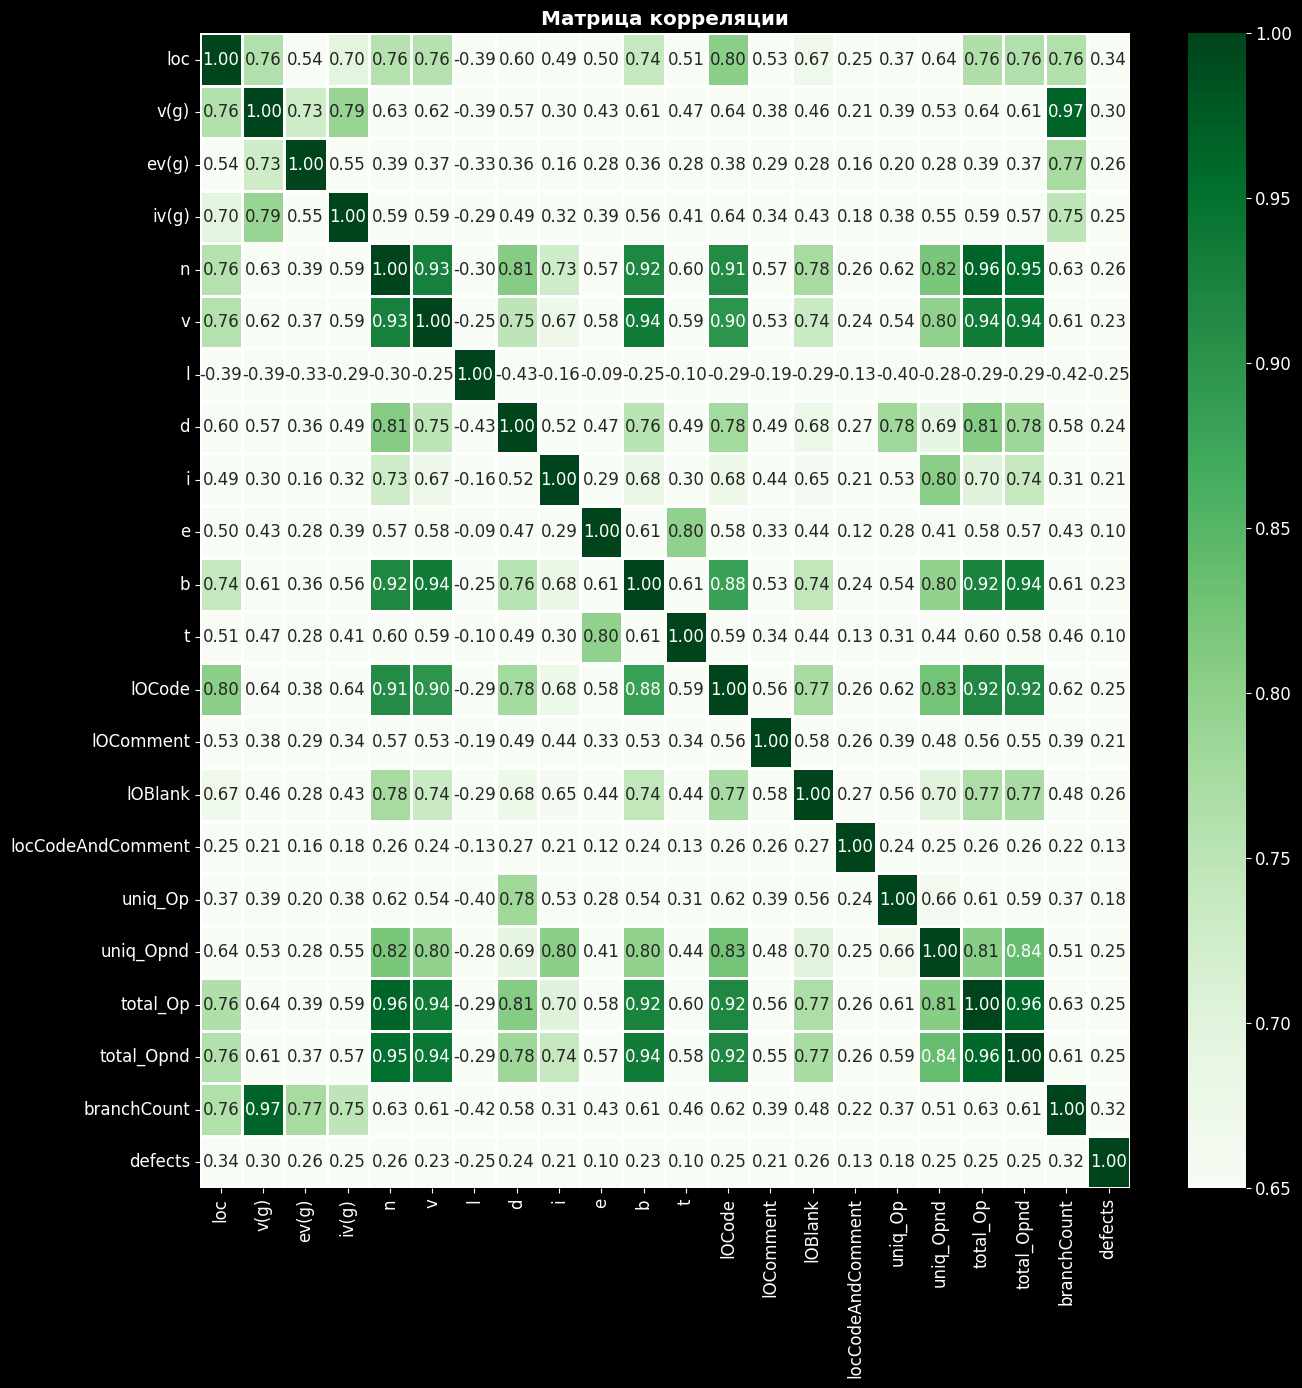

In [9]:
plt.figure(figsize=(15, 15))
plt.title("Матрица корреляции", fontweight="bold")
sns.heatmap(
    df.drop(columns="id").corr(),
    cmap="Greens",
    fmt=".2f",
    annot=True,
    vmin=0.65,
    linewidths=1
)
plt.show()

Посчитаем VIF (коэффициент инфляции дисперсии). Он показывает, насколько увеличивается дисперсия коэффициента оценки из-за линейной зависимости с другими предикторами. 

In [10]:
corr_matrix = np.array(X.corr())
inv_corr_matrix = np.linalg.inv(corr_matrix)
mult_corr_feat = pd.DataFrame(np.diag(inv_corr_matrix), index=X.columns, columns=["VIF"]).sort_values(
    by="VIF", ascending=False
)
mult_corr_feat.style.background_gradient(cmap="Greens")


,VIF
total_Opnd,22.212232
total_Op,21.929240
branchCount,20.946810
v(g),20.141519
n,18.871920
v,13.039168
b,11.419986
lOCode,10.673336
uniq_Opnd,6.067003
d,6.019927


Выберем признаки со значением VIF больше 10.

In [11]:
mult_corr_feat = mult_corr_feat.loc[mult_corr_feat.VIF > 10].index
mult_corr_feat

Index(['total_Opnd', 'total_Op', 'branchCount', 'v(g)', 'n', 'v', 'b',
       'lOCode'],
      dtype='object')

Посмотрим на эти признаки графически, только логарифмируем их (так как они распределены не нормально)

In [12]:
X_cor = np.log(X, where=X > 0)

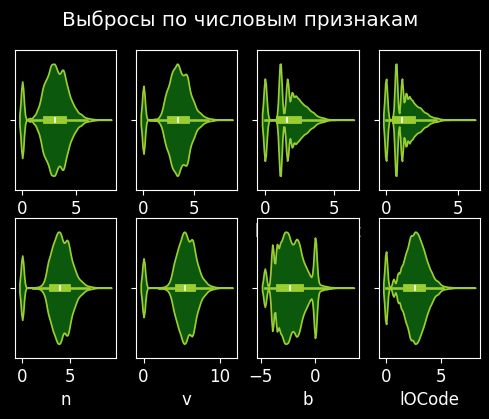

In [13]:
fig, ax = plt.subplots(2, 4)
fig.suptitle("Выбросы по числовым признакам")
i, j = 0, 0

for feat in mult_corr_feat:
    sns.violinplot(
        X_cor[mult_corr_feat],
        x=feat,
        ax=ax[i][j],
        color="darkgreen",
        linecolor="yellowgreen",
    )
    j += 1
    if j == 4:
        i += 1
        j = 0

plt.show()

Видно, насколько схоже распределение у признаков "n", "v", "total_Op", "total_Opnd" и "IOCode".
А также схожи признаки "branchCount" и "v(g)"

В данных есть столбцы со схожими названиями, посмотрим на них:
- "uniq_Op", "total_Op"
- "uniq_Opnd" "total_Opnd"

In [14]:
close_feat = ["uniq_Op", "total_Op", "uniq_Opnd", "total_Opnd"]

<Figure size 1000x800 with 0 Axes>

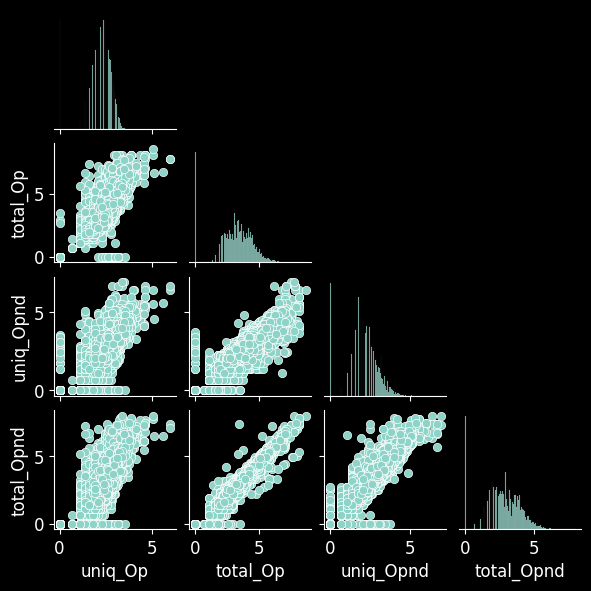

In [15]:
plt.figure(figsize=(10,8))
sns.pairplot(X_cor[close_feat], corner=True, height=1.5)
plt.show()

Эти признаки можно соединить по названию и посчитать среднее значение.\
Из них оставить значимый.

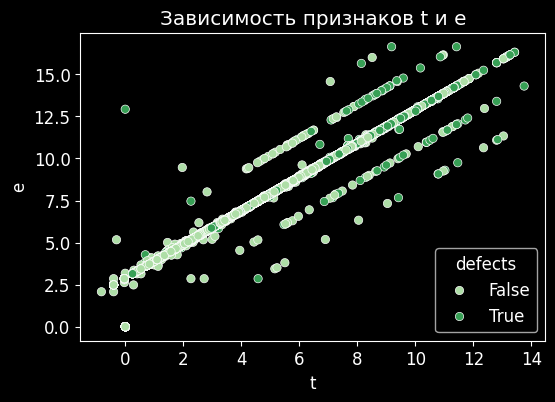

In [16]:
plt.title("Зависимость признаков t и e")
sns.scatterplot(x=X_cor.t, y=X_cor.e, palette="Greens", hue=df.defects)
plt.show()

Так как эти признаки сильно коррелируют только друг с другом, можно перемножить их между собой.

In [17]:
from sklearn.cross_decomposition import PLSRegression

pls = PLSRegression(n_components=10)
pls.fit(X_cor, y)

PLSRegression(n_components=10)

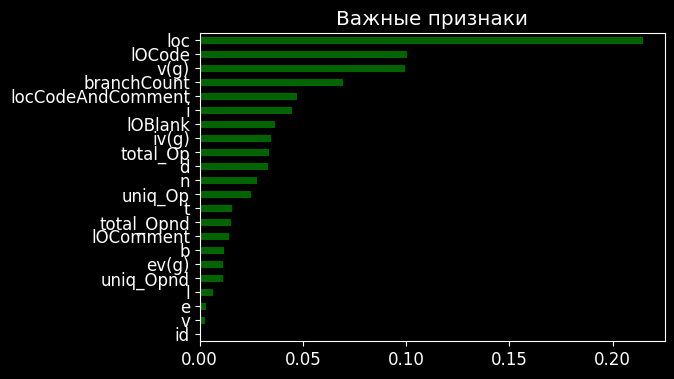

In [18]:
feature_importances = pd.Series(
    abs(pls.coef_[0]),
    index=X.columns,
).sort_values(ascending=True)

plt.title("Важные признаки")
feature_importances.plot(kind="barh", **param_plt_1)
plt.show()

Посмотрим на целевой признак.

In [19]:
df.defects.value_counts()

False    78699
True     23064
Name: defects, dtype: int64

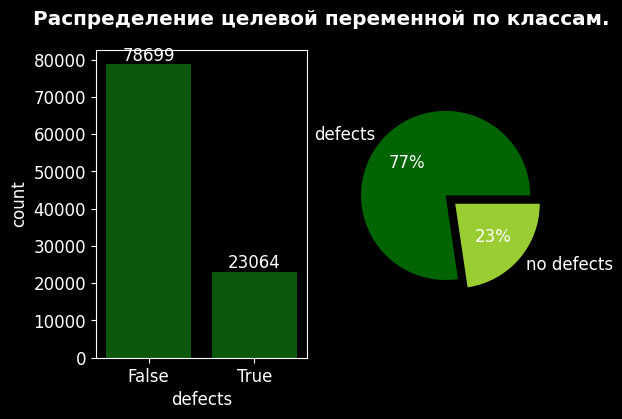

In [20]:
pig, ax = plt.subplots(1, 2)
plt.suptitle("Распределение целевой переменной по классам.", fontweight="bold")
sns.countplot(x=df.defects, stat="count", ax=ax[0], **param_plt_1)
ax[0].bar_label(ax[0].containers[0])
plt.pie(
    df.defects.value_counts(),
    radius=1,
    autopct="%.0f%%",
    colors=["darkgreen", "yellowgreen"],
    labels=["defects", "no defects"],
    explode=(0.15, 0),
)
plt.show()

Очевидно, что мы имеет дисбаланс классов.\
0 класса в 3 раза больше, чем 1го. 

 *Вывод:*
1. Столбец айди дублирует индекс, его можно удалить;
2. В данных обнаружена мультиколинеарность, можно удалить сильно коррелирующие столбцы:
  - из "n", "v", "IOCode" оставить IOCode как значимый;
  - объединить признаки "total_Op" и "uniq_Op";
  - объединить признаки "uniq_Opnd" и "total_Opnd";
  - из "branchCount" и "v(g)" оставить v(g) как более значимый;
  - получить новый признак из "t" и "e".

## <div style="border: 1px solid purple; padding: 10px; color: darkgreen"> Задача 2.</div>
Проведите разбиение на тренировочные и валидационные данные. Проведите необходимую предобработку данных для последующего обучения нейронной сети.

In [21]:
X_train, X_val, y_train_pd, y_val_pd = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
y_train, y_val = y_train_pd.to_numpy(), y_val_pd.to_numpy()

In [22]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [23]:
# так как дисбаланс классов, их делаем балансировку
weights = class_weight.compute_class_weight(
    "balanced", classes=np.unique(y_train), y=y_train
)

class_weight={0:weights[0], 1:weights[1]}
weights

array([0.64653187, 2.20611349])

## <div style="border: 1px solid purple; padding: 10px; color: darkgreen"> Задача 3.</div>
Реализуйте функцию, в которой вы будете определять архитектуру модели. Функция должна возвращать скомпилированную модель.    

In [24]:
def create_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[AUC(curve='ROC', name='roc_auc')],
                  )
    
    return model

## <div style="border: 1px solid purple; padding: 10px; color: darkgreen"> Задача 4.</div>
Обучите модель нейронной сети (без использования методов регуляризации) на исходной тренировочной выборке (без добавления новых признаков). В процессе обучения нужно отслеживать метрику ROC_AUC на каждой эпохе, на валидационных данных.


In [25]:
model = create_model()

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=256,
    class_weight=class_weight,
)

/home/olgatorres/PycharmProjects/ArchitectorAI/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5852 - roc_auc: 0.7628 - val_loss: 0.5610 - val_roc_auc: 0.7880
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5617 - roc_auc: 0.7828 - val_loss: 0.5368 - val_roc_auc: 0.7894
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5564 - roc_auc: 0.7845 - val_loss: 0.5651 - val_roc_auc: 0.7891
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5574 - roc_auc: 0.7852 - val_loss: 0.5845 - val_roc_auc: 0.7894
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5623 - roc_auc: 0.7825 - val_loss: 0.5489 - val_roc_auc: 0.7908
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5554 - roc_auc: 0.7900 - val_loss: 0.5391 - val_roc_auc: 0.7909
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5503 - roc_auc: 0.7915 - val_loss: 0.5264 - val_roc_auc: 0.7902
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5548 - roc_auc: 0.7883 - val_loss: 0.5414 - val_roc_auc:

In [26]:
def plot_graph(train_auc, val_auc, train_loss, val_loss):
    """
    Функция выведет на экран графики ROC-AUC и ошибки на валидационной и обучающей выборках.
    """
    plt.figure(figsize=(12, 9))
    plt.subplot(2, 2, 1)
    epochs = range(1, len(train_auc) + 1)
    plt.title("ROC_AUC", fontweight="bold")
    plt.plot(epochs, train_auc, label="train", **param_plt_1)
    plt.plot(epochs, val_auc, label="val", **param_plt_2)
    plt.xlabel("Эпоха обучения")
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.title("Ошибка", fontweight="bold")
    plt.plot(train_loss, label="train", **param_plt_1)
    plt.plot(val_loss, label="val", **param_plt_2)
    plt.xlabel("Эпоха обучения")
    plt.legend()
    plt.show()

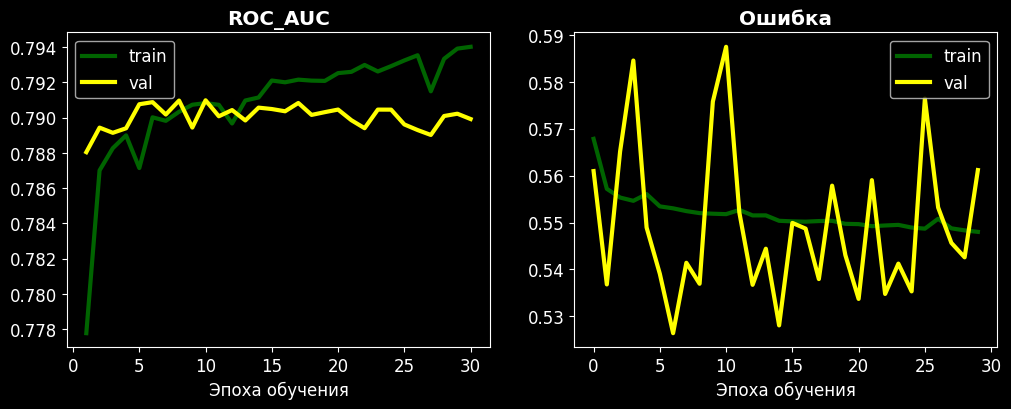

Время обучения: 0.5245 секунд (0.01 минут)


In [27]:
current_time = time.time()
plot_graph(
    history.history["roc_auc"],
    history.history["val_roc_auc"],
    history.history["loss"],
    history.history["val_loss"],
)
print(
    "Время обучения: {:.4f} секунд ({:.2f} минут)".format(
        time.time() - current_time, (time.time() - current_time) / 60
    )
)

На графике видно, что примерно с 7 эпохи модель начинает переобучаться.

In [28]:
treshold = 0.5

In [29]:
model.predict(X_val)
y_pred = [1 if i > treshold else 0 for i in model.predict(X_val)]
roc_auc_score(y_val, y_pred)

637/637 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
637/637 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


0.7258426478839564

## <div style="border: 1px solid purple; padding: 10px; color: darkgreen"> Задача 5.</div>
 Сгенерируйте новые признаки исходя из вашего EDA или наоборот — удалите ненужные признаки, которые препятствуют лучшему качеству модели при обучении. 


In [30]:
X_cor = X.copy()

In [31]:
X_cor.drop(
    columns=["id", "n", "v", "branchCount", 'lOCode'],
    axis=1,
    inplace=True,
)

In [32]:
X_cor["mean_Op"] = np.where(
    (X_cor.uniq_Op != 0) & (X_cor.total_Op != 0), X_cor.total_Op / X_cor.uniq_Op, 0
)
X_cor["mean_Opnd"] = np.where(
    (X_cor.uniq_Opnd != 0) & (X_cor.total_Opnd != 0),
    X_cor.total_Opnd / X_cor.uniq_Opnd,
    0,
)
X_cor["t_e"] = (X_cor.t * X_cor.e) * 0.001
X_cor.drop(
    columns=["total_Op", "uniq_Op", "t", "e", "total_Opnd", "uniq_Opnd"],
    axis=1,
    inplace=True,
)

In [33]:
# X_cor = np.log(X_cor, where=X_cor > 0)

In [34]:
corr_matrix = np.array(X_cor.corr())
inv_corr_matrix = np.linalg.inv(corr_matrix)
mult_corr_feat = pd.DataFrame(np.diag(inv_corr_matrix), index=X_cor.columns, columns=["VIF"]).sort_values(
    by="VIF", ascending=False
)
mult_corr_feat.style.background_gradient(cmap="Greens")

,VIF
b,5.814145
v(g),5.361688
mean_Op,4.793194
loc,4.278652
d,3.994027
lOBlank,3.162147
iv(g),2.931675
i,2.915285
ev(g),2.244136
mean_Opnd,1.976480


In [35]:
X_train, X_val, y_train_pd, y_val_pd = train_test_split(
    X_cor, y, test_size=0.2, random_state=42, stratify=y
)
y_train, y_val = y_train_pd.to_numpy(), y_val_pd.to_numpy()

In [36]:
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

## <div style="border: 1px solid purple; padding: 10px; color: darkgreen"> Задача 6.</div>
Переобучите модель на данных, которые представляют из себя новый датафрейм, и оцените, как изменилось качество модели (то есть вы либо добавили новые признаки, либо удалили старые, либо всё вместе). Исходя из этого примите решение, какие новые признаки хорошо повлияли на качество, а какие нет.

In [37]:
model = create_model()

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=256,
    class_weight={0: weights[0], 1: weights[1]},
)

Epoch 1/30


/home/olgatorres/PycharmProjects/ArchitectorAI/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5883 - roc_auc: 0.7578 - val_loss: 0.5555 - val_roc_auc: 0.7889
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5581 - roc_auc: 0.7860 - val_loss: 0.5777 - val_roc_auc: 0.7901
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5563 - roc_auc: 0.7881 - val_loss: 0.5555 - val_roc_auc: 0.7903
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5590 - roc_auc: 0.7861 - val_loss: 0.5567 - val_roc_auc: 0.7906
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5548 - roc_auc: 0.7886 - val_loss: 0.5634 - val_roc_auc: 0.7902
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5546 - roc_auc: 0.7884 - val_loss: 0.5570 - val_roc_auc: 0.7906
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5498 - roc_auc: 0.7924 - val_loss: 0.5358 - val_roc_auc: 0.7893
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5541 - roc_auc: 0.7895 - val_loss: 0.5307 - val_roc_auc: 0.7894
Epo

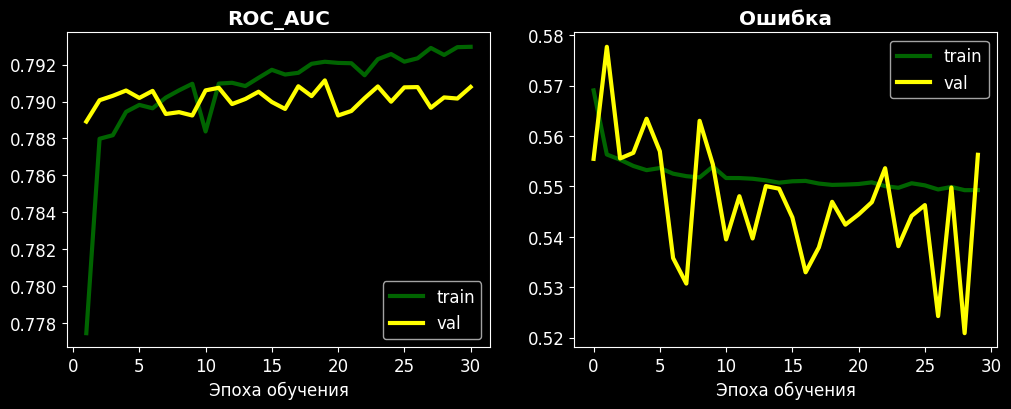

Время обучения: 0.2358 секунд (0.00 минут)


In [38]:
current_time = time.time()
plot_graph(
    history.history["roc_auc"],
    history.history["val_roc_auc"],
    history.history["loss"],
    history.history["val_loss"],
)

print(
    "Время обучения: {:.4f} секунд ({:.2f} минут)".format(
        time.time() - current_time, (time.time() - current_time) / 60
    )
)

In [39]:
model.predict(X_val)
treshold = 0.5
y_pred = [1 if i > treshold else 0 for i in model.predict(X_val)]
roc_auc_score(y_val, y_pred)

637/637 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
637/637 ━━━━━━━━━━━━━━━━━━━━ 1s 967us/step


0.7271674010606454

Добавление новых признаков и удаление мультиколинеарных не сильно отразилось на конечной метрике.\
Только на графике видно, что сама кривая ROC-AUC стала более близка к обучающей.

## <div style="border: 1px solid purple; padding: 10px; color: darkgreen"> Задача 7.</div>
Собрав финальный датасет, который состоит из отфильтрованных (или добавленных) новых признаков, добавьте в вашу модель методы регуляризации — BatchNorm, Dropout, EarlyStopping, а также реализуйте автоматическое сохранение наилучших весов по метрике ROC_AUC на лучшей эпохе.

In [40]:
def create_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[AUC(curve='ROC', name='roc_auc')],
                  )
    
    return model

In [41]:
model = create_model()
early_stopping = EarlyStopping(monitor='val_roc_auc', patience=5)

save_best_weights = ModelCheckpoint(filepath='.weights.h5',
                                    save_weights_only=True,
                                    monitor='val_roc_auc',
                                    mode='max',
                                    save_best_only=True)


history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=256,
    class_weight={0: weights[0], 1: weights[1]},
    callbacks=[early_stopping,save_best_weights]
)



Epoch 1/100


/home/olgatorres/PycharmProjects/ArchitectorAI/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.6331 - roc_auc: 0.7339 - val_loss: 0.5457 - val_roc_auc: 0.7871
Epoch 2/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5753 - roc_auc: 0.7736 - val_loss: 0.5503 - val_roc_auc: 0.7889
Epoch 3/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5665 - roc_auc: 0.7791 - val_loss: 0.5562 - val_roc_auc: 0.7891
Epoch 4/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5593 - roc_auc: 0.7866 - val_loss: 0.5518 - val_roc_auc: 0.7899
Epoch 5/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5597 - roc_auc: 0.7853 - val_loss: 0.5629 - val_roc_auc: 0.7903
Epoch 6/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5596 - roc_auc: 0.7851 - val_loss: 0.5644 - val_roc_auc: 0.7901
Epoch 7/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5625 - roc_auc: 0.7827 - val_loss: 0.5505 - val_roc_auc: 0.7902
Epoch 8/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5618 - roc_auc: 0.7853 - val_loss: 0.5432 - val_roc_auc: 0.7

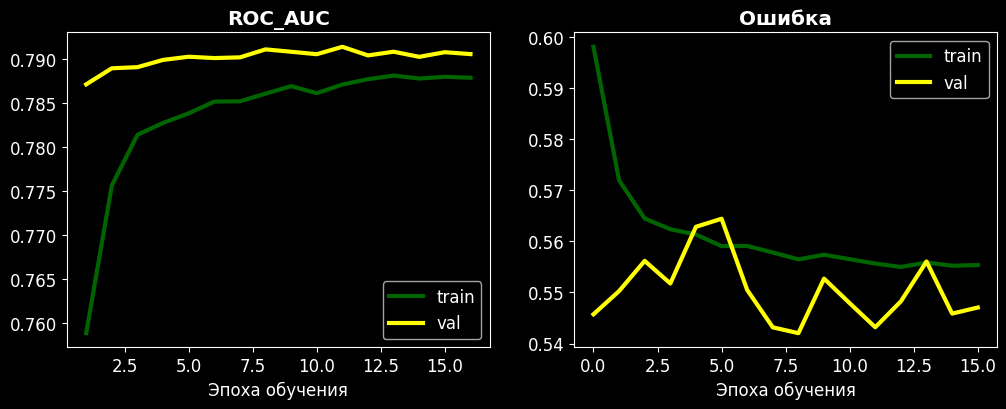

Время обучения: 0.3105 секунд (0.01 минут)


In [42]:
current_time = time.time()
plot_graph(
    history.history["roc_auc"],
    history.history["val_roc_auc"],
    history.history["loss"],
    history.history["val_loss"],
)

print(
    "Время обучения: {:.4f} секунд ({:.2f} минут)".format(
        time.time() - current_time, (time.time() - current_time) / 60
    )
)

In [43]:
model.load_weights(".weights.h5")
y_pred = model.predict(X_val)
roc_auc_score(y_val, y_pred)

637/637 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


0.7913583951877889

## <div style="border: 1px solid purple; padding: 10px; color: darkgreen"> Задача 8.</div>
Напишите вывод по всему проекту, он должен содержать в себе:
- Какие методы регуляризации улучшили качество, а какие плохо повлияли
- Какие признаки повлияли на качество обучения (в лучшую сторону)
- Наилучшую метрику ROC_AUC на валидации

*Вывод:*\
Сложно сказать, какие признаки повлияли на качество модели.\
Метрика не сильно изменилась, на несколько десятых.

Небольшой Dropout (0.1) и BatchNorm после каждого слоя положительно повлияли на обучение,\
кривая стала без скачков и сама метрика выше.\
Добавление дополнительных слоев не изменяло метрику в лучшую строну,\
а вот уменьшение кол-ва нейронов влияло на метрику лучшим образом.\
Лучшая метрика ROC_AUC на валидации = 79.13